In [210]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

In [211]:
def create_graph_from_friendships(friendships):
    """Create a NetworkX graph from a list of friendships."""
    g = nx.Graph()
    g.add_edges_from(friendships)
    return g

In [212]:
# Assuming 0=Mario, 1=Sarah, 2=Raúl, 3=Ana, 4=Enrique, 5=Saúl
friendships = [(0, 1), (0, 2), (0, 3), (4, 1), (4, 2), (5, 3)]
# friendships = [(0, 1), (0, 2), (2, 3), (1, 2)]
g = create_graph_from_friendships(friendships)
dev = qml.device('default.qubit', wires=len(g.nodes))

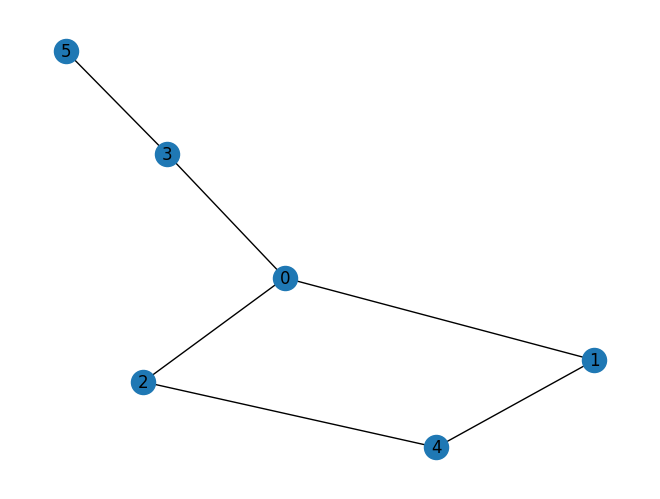

In [213]:
nx.draw(g, with_labels=True)
plt.show()

In [214]:
cost_h, mixer_h = qaoa.min_vertex_cover(g, constrained=False)

In [215]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [226]:
wires = range(6)
depth = 3

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [227]:
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [228]:
optimizer = qml.GradientDescentOptimizer()
steps = 100
params = np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]], requires_grad=True)

In [229]:
print(qml.draw(cost_function, expansion_strategy='device')(params = params))

0: ──H─╭RZZ(0.75)──RZ(1.25)─╭RZZ(0.75)───────────╭RZZ(0.75)──RX(1.00)─────────────────────
1: ──H─╰RZZ(0.75)──RZ(0.50)─│────────────────────│────────────────────╭RZZ(0.75)──RX(1.00)
2: ──H──────────────────────╰RZZ(0.75)──RZ(0.50)─│────────────────────│───────────────────
3: ──H───────────────────────────────────────────╰RZZ(0.75)──RZ(0.50)─│───────────────────
4: ──H────────────────────────────────────────────────────────────────╰RZZ(0.75)──RZ(0.50)
5: ──H────────────────────────────────────────────────────────────────────────────────────

──╭RZZ(0.75)──RZ(1.25)──╭RZZ(0.75)───────────╭RZZ(0.75)──RX(1.00)──────────────────────╭RZZ(0.75)
──╰RZZ(0.75)──RZ(0.50)──│────────────────────│────────────────────╭RZZ(0.75)──RX(1.00)─╰RZZ(0.75)
──╭RZZ(0.75)──RX(1.00)──╰RZZ(0.75)──RZ(0.50)─│────────────────────│────────────────────╭RZZ(0.75)
──│──────────╭RZZ(0.75)──RX(1.00)────────────╰RZZ(0.75)──RZ(0.50)─│────────────────────│─────────
──╰RZZ(0.75)─│───────────RX(1.00)────────────────────────────

In [230]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.49775236 0.4956784  0.95035039]
 [0.53100199 0.56984846 1.0152722 ]]


In [231]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

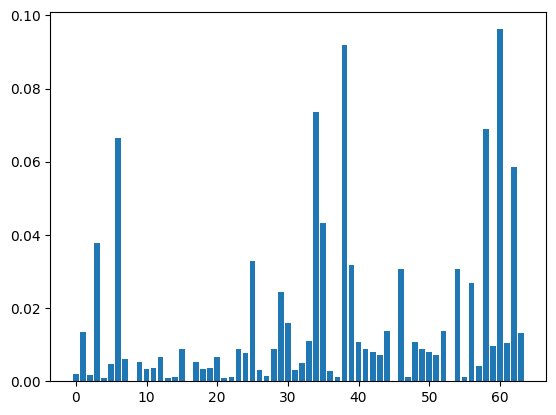

In [232]:
# plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [233]:
probs

tensor([0.00191833, 0.01334428, 0.00166631, 0.03790314, 0.00098797,
        0.0047228 , 0.06659013, 0.00616252, 0.00020385, 0.00519216,
        0.00335994, 0.00365122, 0.00659522, 0.00101728, 0.00105541,
        0.00895194, 0.00020385, 0.00519216, 0.00335994, 0.00365122,
        0.00659522, 0.00101728, 0.00105541, 0.00895194, 0.00771828,
        0.0328422 , 0.00317008, 0.00134327, 0.00881141, 0.02441842,
        0.0159203 , 0.00300629, 0.0049375 , 0.01089318, 0.0736922 ,
        0.04322304, 0.00268462, 0.00107602, 0.09195792, 0.03176377,
        0.01065363, 0.00888601, 0.00797369, 0.00727011, 0.01375799,
        0.00010801, 0.03068052, 0.00118399, 0.01065363, 0.00888601,
        0.00797369, 0.00727011, 0.01375799, 0.00010801, 0.03068052,
        0.00118399, 0.02688915, 0.00412028, 0.06902748, 0.00975282,
        0.09620195, 0.01033909, 0.05851582, 0.01331748], requires_grad=True)

In [234]:
probs.max(), probs.argmax()

(tensor(0.09620195, requires_grad=True), 60)

In [235]:
binario = bin(probs.argmax())[2:]
binario

'111100'